In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-05-30 03:07:23.676769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 03:07:23.676867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 03:07:23.812243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import splitfolders 
splitfolders.ratio("/kaggle/input/augmented-apple-disease-detection-dataset/train_augmented", 
                   output="Apel-sick", 
                   seed=42, 
                   ratio=(.7, .2, .1), 
                   group_prefix=None) 


Copying files: 12000 files [02:20, 85.49 files/s] 


In [6]:
training_dir = os.path.join('Apel-sick', 'train')
testing_dir = os.path.join('Apel-sick', 'test')
validating_dir = os.path.join('Apel-sick', 'val')

In [31]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    shuffle=True,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16
)

validation_generator = validation_datagen.flow_from_directory(
    validating_dir,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
    batch_size=16
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=16
)

Found 8400 images belonging to 4 classes.
Found 2400 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [32]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)
class_count = len(class_names)

{'Apple Scab': 0, 'Black Rot': 1, 'Cedar Apple Rust': 2, 'Healthy': 3}
['Apple Scab', 'Black Rot', 'Cedar Apple Rust', 'Healthy']


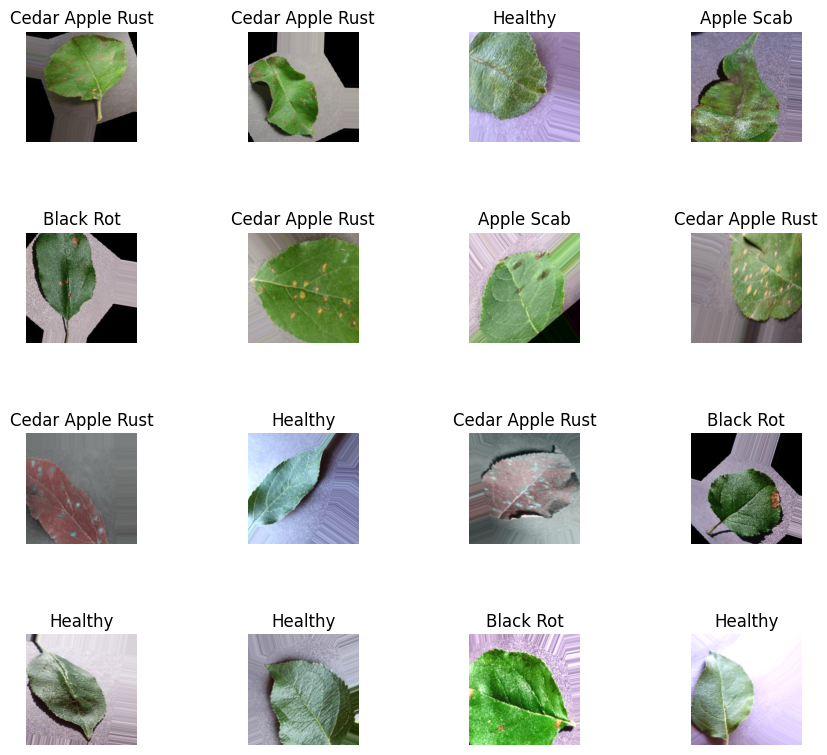

In [33]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()

# **Modeling**

In [34]:
tf.keras.backend.clear_session()

In [39]:
IMAGE_CHANNEL = 3
IMAGE_SIZE = 224
OUTPUT_SIZE = len(class_names)

model = Sequential([
    Conv2D(512, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL), padding='same', strides=(1,1)),
    MaxPooling2D(pool_size=(3, 3)),
    
    Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu', padding='same',strides=(1,1)),
    MaxPooling2D(2,2),
    
    Conv2D(32, (3,3), activation='relu', padding='same',strides=(1,1)),
    MaxPooling2D(2,2),
    Flatten(),
    
    Dense(16, activation='relu'),
    Dense(OUTPUT_SIZE, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 512)  │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 74, 74, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 37, 37, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 9, 9, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,589,812 (6.06 MB)

 Trainable params: 1,589,812 (6.06 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc is not None and val_acc is not None and acc > 0.97 and val_acc > 0.97:
            self.model.stop_training = True

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
my_callback = myCallback()  # Instansiasi myCallback

callbacks = [early_stopping, reduce_lr, my_callback]

In [43]:
total_epochs = 50
training_history = model.fit(train_generator,
                             epochs=total_epochs,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             initial_epoch=0)

Epoch 1/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 172s 243ms/step - accuracy: 0.4375 - loss: 1.1757 - val_accuracy: 0.7517 - val_loss: 0.6057 - learning_rate: 0.0010
Epoch 2/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 125s 236ms/step - accuracy: 0.7283 - loss: 0.6738 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 128s 241ms/step - accuracy: 0.8283 - loss: 0.4225 - val_accuracy: 0.9425 - val_loss: 0.1581 - learning_rate: 0.0010
Epoch 4/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 123s 230ms/step - accuracy: 0.9002 - loss: 0.2766 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 128s 241ms/step - accuracy: 0.9314 - loss: 0.1813 - val_accuracy: 0.9575 - val_loss: 0.1114 - learning_rate: 0.0010
Epoch 6/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 123s 231ms/step - accuracy: 0.9556 - loss: 0.1307 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 

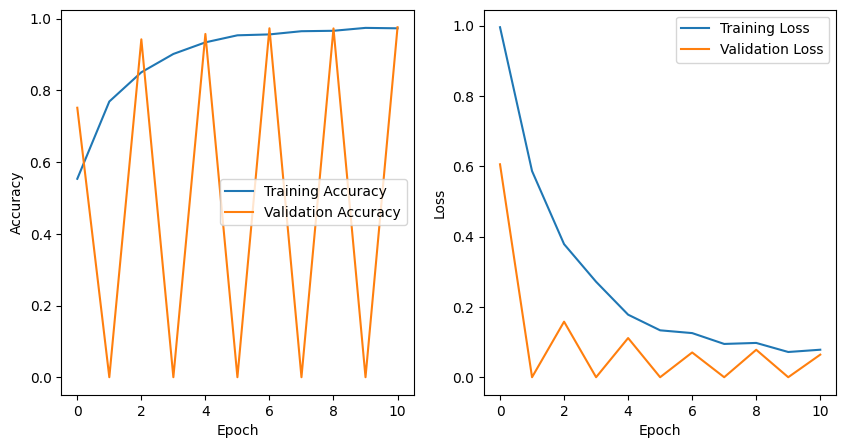

In [44]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [45]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9770 - loss: 0.0587
Test loss: 0.059052109718322754 / Test accuracy: 0.9783333539962769


In [46]:
# Memuat gambar baru dan melakukan prediksi
from tensorflow.keras.preprocessing import image

img_path = '/kaggle/input/augmented-apple-disease-detection-dataset/train_augmented/Cedar Apple Rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction[0])

# Mendapatkan label dari kelas yang diprediksi
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
print(f"The predicted class is: {labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The predicted class is: Cedar Apple Rust


In [47]:
model.save('apelDeepLearningFinal2.h5')